In [1]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from datasets import load_dataset

# Tải dữ liệu
ds = load_dataset('thainq107/ntc-scv')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/570 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.8M [00:00<?, ?B/s]

valid-00000-of-00001.parquet:   0%|          | 0.00/6.35M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/6.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [3]:
import re
import string

def preprocess_text(text):
    # Remove URLs
    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(r" ", text)

    # Remove HTML Tags
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    # Remove punctuation and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    # Remove emojis
    emoji_pattern = re.compile("["

                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U0001F1F2-\U0001F1F4"  # Macau flag
                                u"\U0001F1E6-\U0001F1FF"  # flags
                                u"\U0001F600-\U0001F64F"  # additional emojis
                                u"\U00002702-\U000027B0"  # other symbols
                                u"\U000024C2-\U0001F251"
                                u"\U0001f926-\U0001f937"
                                u"\U0001F1F2"
                                u"\U0001F1F4"
                                u"\U0001F620"
                                u"\u200d"
                                u"\u2640-\u2642"
                                "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    # Normalize whitespace
    text = " ".join(text.split())

    # Convert to lowercase
    text = text.lower()

    return text


In [5]:
!pip install torchtext==0.17.2

# Hàm tạo token từ danh sách câu
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

# Word-based tokenizer
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer("basic_english")

# Xây dựng từ điển (vocabulary)
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(ds['train']['preprocessed_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

# Chuyển đổi tập dữ liệu sang định dạng torchtext
from torchtext.data.functional import to_map_style_dataset

def prepare_dataset(df):
    # Tạo iterator cho tập dữ liệu: (sentence, label)
    for row in df:
        sentence = row['preprocessed_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = prepare_dataset(ds['train'])
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(ds['valid'])
valid_dataset = to_map_style_dataset(valid_dataset)

test_dataset = prepare_dataset(ds['test'])
test_dataset = to_map_style_dataset(test_dataset)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [6]:
import torch

seq_length = 100  # Độ dài tối đa của mỗi câu

# Hàm xử lý batch
def collate_batch(batch):
    # Tách câu và nhãn
    sentences, labels = list(zip(*batch))

    # Chuẩn hóa độ dài câu
    encoded_sentences = [
        sentence + ([0] * (seq_length - len(sentence))) if len(sentence) < seq_length else
        sentence[:seq_length]
        for sentence in sentences
    ]

    # Chuyển đổi thành tensor
    encoded_sentences = torch.tensor(encoded_sentences, dtype=torch.int64)
    labels = torch.tensor(labels)

    return encoded_sentences, labels

from torch.utils.data import DataLoader

batch_size = 128  # Kích thước batch

# Tạo DataLoader cho tập train, valid và test
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)


In [7]:
import time

def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # Compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # Backward pass
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss


In [8]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            # Compute loss
            loss = criterion(predictions, labels)
            losses.append(loss.item())

            # Calculate accuracy
            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss


In [9]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []

    for epoch in range(1, num_epochs + 1):
        epoch_start_time = time.time()

        # Training
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation
        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            best_loss_eval = eval_loss
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)

        # Print epoch summary
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f}".format(
                epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()

    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }

    return model, metrics


In [10]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    # Plot accuracy
    axs[0].plot(epochs, train_accs, label="Training")
    axs[0].plot(epochs, eval_accs, label="Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()

    # Plot loss
    axs[1].plot(epochs, train_losses, label="Training")
    axs[1].plot(epochs, eval_losses, label="Evaluation")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].legend()

    plt.show()


In [12]:
import torch
import torch.nn as nn
!pip install torch


In [13]:
class TransformerEncoderCls(nn.Module):
    def __init__(self, vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout=0.1, device='cpu'):
        super().__init__()
        self.encoder = TransformerEncoder(
            vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim, dropout, device
        )
        self.pooling = nn.AvgPool1d(kernel_size=max_length)
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=2)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.encoder(x)
        output = self.pooling(output.permute(0, 2, 1)).squeeze()
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output


In [15]:
import torch.nn as nn

class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim, dropout=0.1, device='cpu'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(max_length, embed_dim)
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])
        self.device = device

    def forward(self, x):
        N, seq_len = x.shape
        positions = torch.arange(0, seq_len, device=self.device).expand(N, seq_len)
        x = self.embedding(x) + self.position_embedding(positions)
        for layer in self.layers:
            x = layer(x)
        return x


In [16]:
import torch.optim as optim
import os
import torch.nn as nn

# Cấu hình tham số
vocab_size = 10000
max_length = 100
embed_dim = 200
num_layers = 2
num_heads = 4
ff_dim = 128
dropout = 0.1

# Khởi tạo mô hình
model = TransformerEncoderCls(
    vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout
)

# Sử dụng GPU nếu có
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TransformerEncoderCls(
    vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout, device
)
model.to(device)

# Định nghĩa hàm mất mát và tối ưu hóa
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

# Các tham số huấn luyện
num_epochs = 50
save_model = './model'
os.makedirs(save_model, exist_ok=True)
model_name = 'model'

# Huấn luyện mô hình
model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_dataloader,
    valid_dataloader, num_epochs, device
)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

| epoch   1 |    50/  235 batches | accuracy    0.501
| epoch   1 |   100/  235 batches | accuracy    0.512
| epoch   1 |   150/  235 batches | accuracy    0.524
| epoch   1 |   200/  235 batches | accuracy    0.530
-----------------------------------------------------------
| End of epoch   1 | Time: 306.57s | Train Accuracy    0.543 | Train Loss    0.692 | Valid Accuracy    0.502 | Valid Loss    0.686
-----------------------------------------------------------
| epoch   2 |    50/  235 batches | accuracy    0.555
| epoch   2 |   100/  235 batches | accuracy    0.576
| epoch   2 |   150/  235 batches | accuracy    0.608
| epoch   2 |   200/  235 batches | accuracy    0.640
-----------------------------------------------------------
| End of epoch   2 | Time: 298.94s | Train Accuracy    0.683 | Train Loss    0.672 | Valid Accuracy    0.717 | Valid Loss    0.631
-----------------------------------------------------------
| epoch   3 |    50/  235 batches | accuracy    0.701
| epoch   3 

In [17]:
print("Train Accuracy:", metrics['train_accuracy'])
print("Validation Accuracy:", metrics['valid_accuracy'])


Train Accuracy: [0.5426029962546817, 0.6828183520599251, 0.74812734082397, 0.7710674157303371, 0.7834737827715356, 0.8031367041198502, 0.81062734082397, 0.8073501872659176, 0.8146067415730337, 0.8277153558052435, 0.8270131086142322, 0.8288857677902621, 0.8405898876404494, 0.8473782771535581, 0.8359082397003745, 0.8457397003745318, 0.8490168539325843, 0.8504213483146067, 0.8590823970037453, 0.8562734082397003, 0.8565074906367042, 0.8686797752808989, 0.8525280898876404, 0.863061797752809, 0.8717228464419475, 0.8712546816479401, 0.8651685393258427, 0.8738295880149812, 0.8806179775280899, 0.8726591760299626, 0.8834269662921348, 0.8852996254681648, 0.8794475655430711, 0.8874063670411985, 0.886938202247191, 0.8857677902621723, 0.8815543071161048, 0.8815543071161048, 0.8871722846441947, 0.8848314606741573, 0.8977059925093633, 0.8843632958801498, 0.8857677902621723, 0.8946629213483146, 0.8904494382022472, 0.9005149812734082, 0.8944288389513109, 0.9002808988764045, 0.9005149812734082, 0.9021535

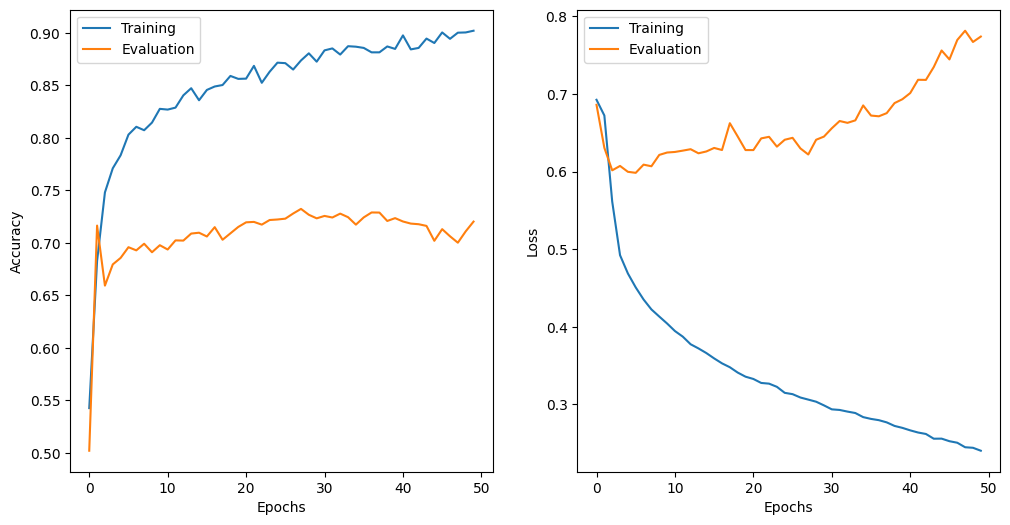

In [18]:
plot_result(
    num_epochs,
    metrics['train_accuracy'],
    metrics['valid_accuracy'],
    metrics['train_loss'],
    metrics['valid_loss']
)
